In [ ]:
%reset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
#from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path

['',
 '/home/knight/matar/.local/lib/python2.7/site-packages/webcolors-1.4-py2.7.egg',
 '/home/knight/matar/.local/lib/python2.7/site-packages/kmodes-0.1.0-py2.7.egg',
 '/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg',
 '/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/setuptools-20.7.0-py2.7.egg',
 '/usr/local/anaconda-2.4.0/lib/python2.7/site-packages',
 '/usr/local/anaconda-2.4.0/lib/python27.zip',
 '/usr/local/anaconda-2.4.0/lib/python2.7',
 '/usr/local/anaconda-2.4.0/lib/python2.7/plat-linux2',
 '/usr/local/anaconda-2.4.0/lib/python2.7/lib-tk',
 '/usr/local/anaconda-2.4.0/lib/python2.7/lib-old',
 '/usr/local/anaconda-2.4.0/lib/python2.7/lib-dynload',
 '/home/knight/matar/.local/lib/python2.7/site-packages',
 '/usr/local/anaconda-2.4.0/lib/python2.7/site-packages/wx-3.0-gtk2',
 '/usr/local/anaconda-2.4.0/lib/python2.7/site-packages/IPython/extensions',
 '/home/knight/matar/.ipython']

In [4]:
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/pacpy')
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/ecogtools')
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/')


In [65]:
from PAC_func import _phase_amplitude_coupling_edited

In [6]:
import connectivity as cnn
from utils.loadmat import loadmat
import seaborn as sns
import pandas as pd
import itertools
import os
import scipy.io as spio

In [7]:
base = '/home/knight/matar/MATLAB/DATA/Avgusta'

In [8]:
df = pd.read_csv(os.path.join(base, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv'))

In [9]:
df_subj = df[['subj','task']].drop_duplicates()
df_subj['f1'] = np.nan
df_subj['f2'] = np.nan

condition = df_subj.subj.isin(['GP15', 'CP7', 'ST27'])
df_subj.loc[condition, 'f1'] = 5
df_subj.loc[condition, 'f2'] = 9

condition = df_subj.subj.isin(['GP35', 'JH2'])
df_subj.loc[condition, 'f1'] = 7
df_subj.loc[condition, 'f2'] = 11

condition = df_subj.subj.isin(['GP28', 'ST4', 'ST32'])
df_subj.loc[condition, 'f1'] = 4
df_subj.loc[condition, 'f2'] = 8

condition = df_subj.subj.isin(['JH10'])
df_subj.loc[condition, 'f1'] = 3
df_subj.loc[condition, 'f2'] = 8

condition = df_subj.subj.isin(['JH17'])
df_subj.loc[condition, 'f1'] = 3
df_subj.loc[condition, 'f2'] = 6

condition = df_subj.subj.isin(['JH6'])
df_subj.loc[condition, 'f1'] = 6
df_subj.loc[condition, 'f2'] = 9



In [10]:
df_subj = df_subj[df_subj.f1.notnull()] #drop subjs without frequency bands identified

In [11]:
varname_dict = {'EmoGen':'onsets_resp_corr_g','EmoRep':'onsets_resp_corr_g', 
             'FaceEmo':'onsets_resp_corr_g', 'FaceGen':'onsets_resp_corr_g', 
            'SelfAud':'onsets_resp_g', 'SelfVis':'onsets_resp_g',
            'DecisionAud': 'onsets_resp', 'DecisionVis' : 'onsets_stim'}

# filter outside function
## with circshift / random

In [12]:
print data_am.shape
tmp = np.roll(data_am, 1, axis = 1)
tmp[0,0] in data_am[0,:]
tmp[0,1] == data_am[0,0]

NameError: name 'data_am' is not defined

In [75]:
for row in [df_subj.ix[47]]: #.iterrows():
    subj, task, f1, f2 = row
    print (subj, task, f1, f2)
    
    #load data
    filename = os.path.join(base, 'Subjs', subj, task, 'gdat_notch.mat')
    data_dict = loadmat(filename)
    gdat = data_dict['gdat']
    
    onsets_resp_name = varname_dict[task]
    filename = os.path.join(base, 'Subjs', subj, task, onsets_resp_name + '.mat')
    data_dict = loadmat(filename)
    onsets_resp = data_dict[onsets_resp_name]
    
    filename = os.path.join(base, 'Subjs', subj, task,  'subj_globals.mat')
    data_dict = loadmat(filename)
    srate = data_dict['srate']
    
    #define D and R elecs and their indices
    D = df[(df.subj == subj) & (df.task == task) & (df.pattern == 'D')].elec.values
    R = df[(df.subj == subj) & (df.task == task) & (df.pattern == 'R')].elec.values
    if ((len(D) < 1) | (len(R) < 1)):
        continue
    pairs = (list(itertools.product(D, R)))
    ixs = np.array(pairs)-1 #adjust for python indexing
    
    #edited method - filter outside
    data = gdat
    sfreq = srate
    f_phase = np.array((f1,f2))
    f_amp = np.array((70.0,150.0))
    ev = onsets_resp.astype('int')
    ev2 = np.random.randint(min(ev), max(ev), len(ev))

    t_inc = 0.001 #1ms
    tmin = -.50
    tmax = tmin+t_inc
    p = []

    #params for _edited function
    ixs = np.array(ixs, ndmin=2)
    f_phase = np.atleast_2d(f_phase)
    f_amp = np.atleast_2d(f_amp)

    #filter data
    data_ph, data_am, ix_map_ph, ix_map_am = cnn._pre_filter_ph_am(
        data, sfreq, ixs, f_phase, f_amp, npad='auto', hi_phase=True)

    #circshift
    #data_am = np.roll(data_am, 5000, axis = 1)
    
    data = [(data_ph, ix_map_ph), (data_am, ix_map_am)]

    #calculate pac for each time bin
    while tmin<0:
        pac = _phase_amplitude_coupling_edited(data, sfreq, f_phase, f_amp, ixs,
                                                                pac_func='plv', ev=ev,
                                                                tmin=tmin, tmax=tmax,
                                                                baseline=None,
                                                                npad='auto',
                                                                concat_epochs=True,
                                                                verbose=None,
                                                                to_filter=False, ev2 = ev2)

        p.append(pac)
        tmin+=t_inc
        tmax+=t_inc

    #save
    pmatrix = np.array(p).squeeze()
    filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', 'random', 'data', '{0}_{1}_PAC_resp-500.mat'.format(subj, task))
    spio.savemat(filename, {'pac_matrix':pmatrix, 'pairs': pairs, 'ixs':ixs})

    #plot
    for i in range(pmatrix.shape[1]):
        p = pmatrix[:,i]
        ix = ixs[i]
        f, ax = plt.subplots()
        ax.plot(np.arange(-500, 0, 1), p) 
        #e_ph, e_am = idx_dict[tuple(ix)]
        e_ph, e_am = ix+1 #adjust naming from python index to real index
        ax.set_title('{0} {1} - e{2} phase, e{3} amp, {4}-{5}Hz'.format(subj, task, e_ph, e_am, f1, f2))
        filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', 'random', 'figures', '{0}_{1}_PAC_e{2}_e{3}.png'.format(subj, task, e_ph, e_am))
        f.savefig(filename)
        plt.close()


('GP15', 'EmoGen', 5.0, 9.0)
random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[........................................] 100.00000 |    random onsets
No baseline correction applied...
(1, 1)
[...........

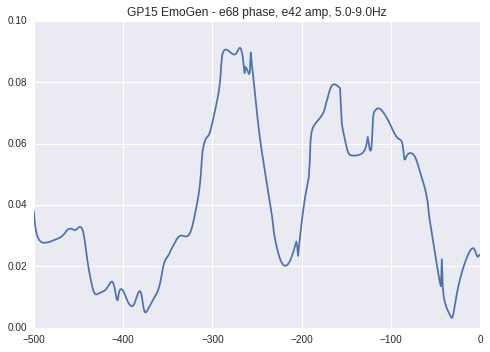

# cluster PAC values
## with circshift or random

In [78]:
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import rgb2hex, colorConverter

sns.set_palette('Set1', 10, 0.65)
palette = sns.color_palette()
hc.set_link_color_palette(map(rgb2hex, palette))
sns.set_style('white')

no_spine = {'left': True, 'bottom': True, 'right': True, 'top': True}



In [79]:
subj_dict = dict()
for row in [df_subj.ix[47]]: #.iterrows():
    subj, task, f1, f2 = row
    print (subj, task, f1, f2)
    
    filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved','random', 'data', '{0}_{1}_PAC_resp-500.mat'.format(subj, task))
    if not(os.path.exists(filename)):
        continue    
    data_dict = loadmat(filename)
    pac_matrix, ixs, pairs = [data_dict[k] for k in ['pac_matrix','ixs', 'pairs']]
    subj_dict[(subj, task)] = [pac_matrix, ixs, pairs]
    
    dfpac = pd.DataFrame(pac_matrix).transpose()
    dfpac.index = [tuple(x) for x in pairs]
    
    k=5
    distance = pdist(dfpac, 'correlation') #distance matrix

    Z = hc.linkage(distance, method = 'complete') #linkage matrix
    clusters = hc.fcluster(Z, k, criterion='maxclust')
    cutoff = Z[-(k-1),2]  

    f, ax = plt.subplots(figsize = (20,5))
    dend = hc.dendrogram(Z, labels = dfpac.index, ax = ax, leaf_font_size = 12, color_threshold = cutoff)
    ax.set_title('{0} {1} resp-500'.format(subj, task))
    sns.despine(**no_spine);

    filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', 'random', 'dendro', '{0}_{1}_PAC_dendro.png'.format(subj, task))
    plt.savefig(filename)

    filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', 'random', 'dendro', '{0}_{1}_PAC_dendro.csv'.format(subj, task))
    dfpac['cluster'] = clusters
    dfpac['idx'] = [tuple(x) for x in ixs]
    dfpac[['cluster', 'idx']].to_csv(filename)
    plt.close()


('GP15', 'EmoGen', 5.0, 9.0)


In [80]:
subj, task = 'GP15', 'EmoGen'
filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', 'random', 'dendro', '{0}_{1}_PAC_dendro.csv'.format(subj, task))
dfgp15 = pd.read_csv(filename)
dfgp15.columns = ['pairs','cluster','idx']
cluster = dfgp15.cluster

filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved','random', 'data', '{0}_{1}_PAC_resp-500.mat'.format(subj, task))  
data_dict = loadmat(filename)
pac_matrix, ixs, pairs = [data_dict[k] for k in ['pac_matrix','ixs', 'pairs']]
dfpca = pd.DataFrame(pac_matrix).transpose()


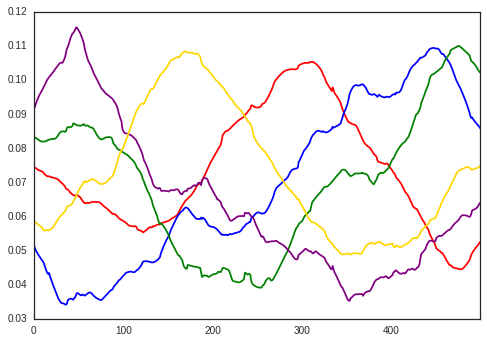

In [81]:
dfpca.ix[cluster == 1].mean().plot(color = 'red')
dfpca.ix[cluster == 2].mean().plot(color = 'blue')
dfpca.ix[cluster == 3].mean().plot(color = 'green')
dfpca.ix[cluster == 4].mean().plot(color = 'purple')
dfpca.ix[cluster == 5].mean().plot(color = 'gold')

# histogram of PAC values

In [14]:
#concatenate all the pac matrices
pac_dict = dict()
for row in df_subj.iterrows():
    subj, task, f1, f2 = row[1]
    print (subj, task, f1, f2)
    
    filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved','data', '{0}_{1}_PAC_resp-500.mat'.format(subj, task))
    if not(os.path.exists(filename)):
        continue    
    data_dict = loadmat(filename)
    pac_matrix, ixs, pairs = [data_dict[k] for k in ['pac_matrix','ixs', 'pairs']]
    pac_dict[(subj, task)] = pac_matrix

('CP7', 'DecisionAud', 5.0, 9.0)
('GP15', 'EmoGen', 5.0, 9.0)
('GP15', 'EmoRep', 5.0, 9.0)
('GP15', 'FaceEmo', 5.0, 9.0)
('GP15', 'FaceGen', 5.0, 9.0)
('GP15', 'SelfAud', 5.0, 9.0)
('GP15', 'SelfVis', 5.0, 9.0)
('GP28', 'SelfAud', 4.0, 8.0)
('GP28', 'SelfVis', 4.0, 8.0)
('GP35', 'EmoGen', 7.0, 11.0)
('GP35', 'EmoRep', 7.0, 11.0)
('GP35', 'FaceEmo', 7.0, 11.0)
('GP35', 'FaceGen', 7.0, 11.0)
('JH10', 'EmoRep', 3.0, 8.0)
('JH10', 'SelfAud', 3.0, 8.0)
('JH17', 'EmoRep', 3.0, 6.0)
('JH17', 'SelfAud', 3.0, 6.0)
('JH17', 'SelfVis', 3.0, 6.0)
('JH2', 'EmoGen', 7.0, 11.0)
('JH2', 'FaceEmo', 7.0, 11.0)
('JH2', 'SelfAud', 7.0, 11.0)
('JH2', 'SelfVis', 7.0, 11.0)
('JH6', 'FaceEmo', 6.0, 9.0)
('JH6', 'SelfAud', 6.0, 9.0)
('ST27', 'DecisionVis', 5.0, 9.0)
('ST32', 'DecisionVis', 4.0, 8.0)
('ST4', 'EmoRep', 4.0, 8.0)
('ST4', 'SelfAud', 4.0, 8.0)


In [16]:
pacs = pac_dict.values()
pacs = [item for sublist in pacs for item in sublist]
pacs = [item for sublist in pacs for item in sublist]

0.18405337368656133

(array([  1.20390000e+04,   2.44780000e+04,   2.04870000e+04,
          1.14210000e+04,   4.77500000e+03,   1.65300000e+03,
          4.75000000e+02,   9.90000000e+01,   1.80000000e+01,
          5.00000000e+00]),
 array([-0.09240678, -0.05100625, -0.00960572,  0.03179481,  0.07319533,
         0.11459586,  0.15599639,  0.19739691,  0.23879744,  0.28019797,
         0.32159849]),
 <a list of 10 Patch objects>)

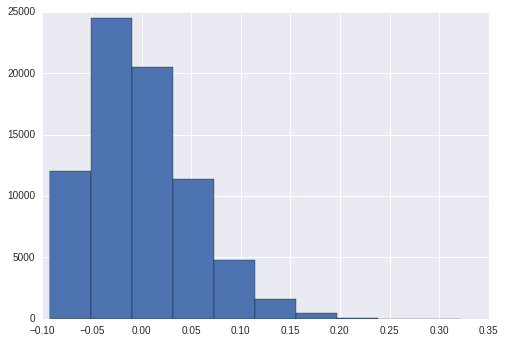

In [19]:
plt.hist(pacs-np.mean(pacs))

In [ ]:
pacmtx = np.concatenate((gp15, gp35, jh2), axis = 1)
ix = np.concatenate((gp15ix, gp35ix, jh2ix), axis = 0)

In [ ]:
dfpca = pd.DataFrame(pacmtx).transpose()

In [ ]:
distance = pdist(dfpca, 'cosine') #distance matrix
Z = hc.linkage(distance, method = 'complete') #linkage matrix
incon = hc.inconsistent(Z) #inconsistency
coph = squareform(hc.cophenet(Z)) #cophenet
#cutoff = median(incon[:,-1])
cutoff = .5
f, ax = plt.subplots(figsize = (20,5))
dend = hc.dendrogram(Z, color_threshold=cutoff, ax = ax, leaf_font_size = 12)


In [ ]:
cluster = hc.fcluster(Z, cutoff, criterion = 'distance')
dfpca.ix[cluster == 1].mean().plot(color = 'green')
dfpca.ix[cluster == 2].mean().plot(color = 'red')
dfpca.ix[cluster == 3].mean().plot(color = 'cyan')

In [ ]:
cluster = hc.fcluster(Z, cutoff, criterion = 'distance')
dfpca.ix[cluster == 1].mean().plot(color = 'green')
dfpca.ix[cluster == 2].mean().plot(color = 'red')
dfpca.ix[cluster == 3].mean().plot(color = 'cyan')
dfpca.ix[cluster == 4].mean().plot(color = 'purple')

In [ ]:
plt.plot(dfpca.ix[cluster == 1].transpose())


# run with filtering inside function

In [ ]:
#edited method - filter inside
data = gdat
sfreq = srate
f_phase = np.array((5.0,9.0))
f_amp = np.array((70.0,150.0))
ev = onsets_resp.astype('int')

t_inc = 0.01
tmin = -.50
tmax = tmin+t_inc
p = []

pac_out_orig = _phase_amplitude_coupling_edited(data, sfreq, f_phase, f_amp, ixs,
    pac_func='plv', ev=ev,
    tmin=tmin, tmax=tmax,
    baseline=None,
    npad='auto',
    concat_epochs=True,
    verbose=None,
    to_filter=True, return_data = False)

In [ ]:
data = gdat
sfreq = srate
f_phase = np.array((5,9))
f_amp = np.array((70,150))
ev = onsets_resp.astype('int')

t_inc = 0.01
tmin = -.50
tmax = tmin+t_inc
p = []

ixs = np.array(ixs, ndmin=2)
f_phase = np.atleast_2d(f_phase)
f_amp = np.atleast_2d(f_amp)

pac_out_orig = cnn._phase_amplitude_coupling(data, sfreq, f_phase, f_amp, ixs,
                                              pac_func='plv', ev=ev,
                                              tmin=tmin, tmax=tmax,
                                              baseline=None, 
                                              npad='auto',
                                              concat_epochs=True,
                                              verbose=False)

In [ ]:
pac_out_orig

In [ ]:
def run_pac(data, sfreq, f_phase, f_amp, ix, ev, tmin, tmax):
    p = []
    while tmin < 0:
        pac_out = cnn._phase_amplitude_coupling(data, sfreq, f_phase, f_amp, [ix],
                                              pac_func='plv', ev=ev,
                                              tmin=tmin, tmax=tmax,
                                              baseline=None, 
                                              npad='auto',
                                              concat_epochs=True,
                                              verbose=False)
        p.append(pac_out)
        tmin+=t_inc
        tmax+=t_inc
    return np.array(p).squeeze()

In [ ]:
#resp - 500 PAC
data = gdat
sfreq = srate
f_phase = np.array((5,9))
f_amp = np.array((70,150))
ev = onsets_resp.astype('int')
t_inc = 0.01
tmin = -.5
tmax = tmin+t_inc

for ix in [ixs[0]]:
    p = run_pac(data, sfreq, f_phase, f_amp, ix, ev, tmin, tmax)
    f, ax = plt.subplots()
    ax.plot(np.arange(tmin*1000, 0, t_inc*1000), p) 
    e_ph, e_am = idx_dict[tuple(ix)]
    ax.set_title('e{0} phase, e{1} amp'.format(e_ph, e_am))
    filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', '{0}_{1}_PAC_e{2}_e{3}.png'.format(subj, task, e_ph, e_am))
    #f.savefig(filename)
    #plt.close()
    print filename

# baseline PAC - build distribution with resampling


In [ ]:
data = gdat
sfreq = srate
f_phase = np.array((3,9))
f_amp = np.array((70,150))
ev = onsets_stim.astype('int') #stimulus onsets
tmin = -.5
tmax = .01

l = [np.random.permutation(50) for x in range(10)]
l = [item for sublist in l for item in sublist]
tmins = [x/100.0*-1 for x in l]

p=[]

In [ ]:
#params for _edited function
ixs = np.array(ixs, ndmin=2)
f_phase = np.atleast_2d(f_phase)
f_amp = np.atleast_2d(f_amp)

#filter data
data_ph, data_am, ix_map_ph, ix_map_am = _pre_filter_ph_am(
    data, sfreq, ixs, f_phase, f_amp, npad='auto', hi_phase=True)

data = [(data_ph, ix_map_ph), (data_am, ix_map_am)]

for i, tmin in enumerate(tmins):
    print i
    t_inc = 0.01
    tmax = tmin+t_inc
    
    pac = _phase_amplitude_coupling_edited(data, sfreq, f_phase, f_amp, ixs,
                                                            pac_func='plv', ev=ev,
                                                            tmin=tmin, tmax=tmax,
                                                            baseline=None,
                                                            npad='auto',
                                                            concat_epochs=True,
                                                            verbose=None,
                                                            to_filter=False, return_data = False)
    
    p.append(pac)
    
#save
pmatrix = np.array(p).squeeze()
filename = os.path.join(base, 'PCA', 'PLV','PAC','time_resolved', '{0}_{1}_PAC_stim-500.mat'.format(subj, task))
spio.savemat(filename, {'pac_matrix':pmatrix, 'ixs':ixs})


# troubleshoot 

In [25]:
from mne.baseline import rescale
from mne.utils import _time_mask


In [23]:
baseline=None
baseline_kind='mean'
scale_amp_func=None
use_times=None
npad='auto'
return_data=False
concat_epochs=True
n_jobs=1,
verbose=None
to_filter = False

In [58]:
pac_func = 'plv'
from pacpy import pac as ppac
func = getattr(ppac, pac_func)
func

<function pacpy.pac.plv>

In [70]:
for row in [df_subj.ix[47]]: #.iterrows():
    subj, task, f1, f2 = row
    print (subj, task, f1, f2)
    
    #load data
    filename = os.path.join(base, 'Subjs', subj, task, 'gdat_notch.mat')
    data_dict = loadmat(filename)
    gdat = data_dict['gdat']
    
    onsets_resp_name = varname_dict[task]
    filename = os.path.join(base, 'Subjs', subj, task, onsets_resp_name + '.mat')
    data_dict = loadmat(filename)
    onsets_resp = data_dict[onsets_resp_name]
    
    filename = os.path.join(base, 'Subjs', subj, task,  'subj_globals.mat')
    data_dict = loadmat(filename)
    srate = data_dict['srate']
    
    #define D and R elecs and their indices
    D = df[(df.subj == subj) & (df.task == task) & (df.pattern == 'D')].elec.values
    R = df[(df.subj == subj) & (df.task == task) & (df.pattern == 'R')].elec.values
    if ((len(D) < 1) | (len(R) < 1)):
        continue
    pairs = (list(itertools.product(D, R)))
    ixs = np.array(pairs)-1 #adjust for python indexing
    
    #edited method - filter outside
    data = gdat
    sfreq = srate
    f_phase = np.array((f1,f2))
    f_amp = np.array((70.0,150.0))
    ev = onsets_resp.astype('int')
    ev2 = np.random.randint(min(ev), max(ev), len(ev))
    
    t_inc = 0.001 #1ms
    tmin = -.50
    tmax = tmin+t_inc
    p = []

    #params for _edited function
    ixs = np.array(ixs, ndmin=2)
    f_phase = np.atleast_2d(f_phase)
    f_amp = np.atleast_2d(f_amp)

    #filter data
    data_ph, data_am, ix_map_ph, ix_map_am = cnn._pre_filter_ph_am(
        data, sfreq, ixs, f_phase, f_amp, npad='auto', hi_phase=True)

    #circshift
    #data_am = np.roll(data_am, 5000, axis = 1)
    
    ixs_new = [(ix_map_ph[i], ix_map_am[j]) for i, j in ixs]

    if ev is not None: 
        use_times = [tmin, tmax] if use_times is None else use_times
        ev_grouping = np.ones_like(ev) 
        data_ph, times, msk_ev = cnn._array_raw_to_epochs(
            data_ph, sfreq, ev, tmin, tmax)        
        print times
        data_am, times, msk_ev = cnn._array_raw_to_epochs(
            data_am, sfreq, ev2, tmin, tmax) #EDIT FOR RANDOM ONSETS OF AMPLITUDE
        print times
        print 'random onsets'
        # In case we cut off any events
        ev, ev_grouping = [i[msk_ev] for i in [ev, ev_grouping]]
        # Baselining before returning
        rescale(data_am, times, baseline, baseline_kind, copy=False)
        msk_time = _time_mask(times, *use_times)
        data_am, data_ph = [i[..., msk_time] for i in [data_am, data_ph]]
        # print (data_am.shape, data_am[0])
        # Stack epochs to a single trace if specified
        if concat_epochs is True:
            ev_unique = np.unique(ev_grouping)
            concat_data = []
            for i_ev in ev_unique:
                msk_events = ev_grouping == i_ev
                concat_data.append([np.hstack(i[msk_events])
                                    for i in [data_am, data_ph]])
            data_am, data_ph = zip(*concat_data)
    else:
        data_ph = np.array([data_ph])
        data_am = np.array([data_am])         
    data_ph = list(data_ph)
    data_am = list(data_am)
    # print(len(data_am), len(data_ph))
    if scale_amp_func is not None:
        for i in range(len(data_am)):
            data_am[i] = scale_amp_func(data_am[i], axis=-1)

    n_ep = len(data_ph)
    pac = np.zeros([n_ep, len(ixs_new)])
    for iep, (ep_ph, ep_am) in enumerate(zip(data_ph, data_am)):
        for iix, (i_ix_ph, i_ix_am) in enumerate(ixs_new):
            # f_phase and f_amp won't be used in this case
            pac[iep, iix] = func(ep_ph[i_ix_ph], ep_am[i_ix_am],
                                 f_phase, f_amp, filterfn=False)

('GP15', 'EmoGen', 5.0, 9.0)
[-0.5]
[-0.5]
random onsets
No baseline correction applied...


0.081043381568839154

In [51]:
data_ph[0].shape

(17, 147)

In [38]:
ev = onsets_resp.astype('int')
ev_grouping = np.ones_like(ev) 

In [40]:
msk_ev

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,